In [2]:
import cv2
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

from google.colab import drive
import os
import shutil
import numpy as np

from google.colab.patches import cv2_imshow

from knn import KNN

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
base_path = "/content/gdrive/MyDrive/esilv/ML_for_fintech/cheques/cheque"
!ls "/content/gdrive/MyDrive/esilv/ML_for_fintech/cheques/cheque"

axa  bnp  bpop	bpos  bred  ca	cdn  ce  cic  cm  hsbc	lcl  sg


## Data augmentation functions

Function from [this site](https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5).

In [5]:
def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img

In [6]:
def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        raise ValueError('Value should be less than 1 and greater than 0')
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img

In [7]:
def vertical_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
    img = fill(img, h, w)
    return img

In [8]:
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

In [9]:
def zoom(img, value):
    if value > 1 or value < 0:
        raise ValueError('Value for zoom should be less than 1 and greater than 0')
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, h, w)
    return img

In [10]:
def channel_shift(img, value):
    value = int(random.uniform(-value, value))
    img = img + value
    img[:,:,:][img[:,:,:]>255]  = 255
    img[:,:,:][img[:,:,:]<0]  = 0
    img = img.astype(np.uint8)
    return img

In [11]:
def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img

In [12]:
def vertical_flip(img, flag):
    if flag:
        return cv2.flip(img, 0)
    else:
        return img

In [13]:
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

In [14]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    if prob > 1 or prob < 0:
        raise ValueError('Probability must be between 0 and 1')
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

## Data augmentation

In [15]:
def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

In [16]:
def single_transformation(img, hshift, vshift, lbright, hbright, zoom_ratio, chshift, hflip, vflip, rot, noise_prob):
    result = horizontal_shift(img, hshift)
    result = vertical_shift(result, vshift)
    result = brightness(result, lbright, hbright)
    result = zoom(result, zoom_ratio)
    result = channel_shift(result, chshift)
    result = horizontal_flip(result, hflip)
    result = vertical_shift(result, vflip)
    result = rotation(result, rot)
    result = sp_noise(result, noise_prob)
    return result

In [17]:
def augment_image(path, height, ratio, width, hshift, vshift, lbright, hbright, zoom_ratio, chshift, hflip, vflip, rot, noise_prob):
    img = cv2.imread(path)
    img = fill(img, height, width)
    hflip_table = np.random.binomial(1, hflip, ratio)
    vflip_table = np.random.binomial(1, vflip, ratio)
    images = [single_transformation(img, hshift, vshift, lbright, hbright, zoom_ratio, chshift, hflip_table[i], vflip_table[i], rot, noise_prob) for i in range(ratio)]
    return images

In [18]:
def save_to_test_train_folder(dest_path, class_name, images, image_name, train):
    train_folder = os.path.join(dest_path, 'train', class_name)
    test_folder = os.path.join(dest_path, 'test', class_name)
    train_or_test = np.random.binomial(1, train, len(images))

    if not os.path.exists(train_folder):
        os.makedirs(train_folder)

    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    for i in range(len(images)):
        folder = train_folder if train_or_test[i] else test_folder
        name = f'{image_name}_{str(i)}.jpg'
        path = os.path.join(folder, name)
        cv2.imwrite(path, images[i])

In [19]:
def augment_from_folder(path, dest_path, ratio, height, width, train=.8, hshift=.2, vshift=.2, lbright=.5, hbright=1.5, zoom_ratio=.9, chshift=12, hflip=.1, vflip=.1, rot=30, noise_prob=.1):
    if ratio < 1:
        raise ValueError('ratio must be an integer greater than 1')

    # Gets all possible classes
    _, dirs, _ = next(os.walk(path))
    for i in range(len(dirs)):
        class_name = dirs[i]
        path_to_class = os.path.join(path, class_name)
        files = get_files_from_folder(path_to_class)
        for f in files:
            image_name = '.'.join(f.split('.')[:-1])
            image_path = os.path.join(path_to_class, f)
            images = augment_image(image_path, height, ratio, width, hshift, vshift, lbright, hbright, zoom_ratio, chshift, hflip, vflip, rot, noise_prob)
            save_to_test_train_folder(dest_path, class_name, images, image_name, train)


## Test augmentation

In [20]:
dataset_path = '/content/dataset'

In [23]:
augment_from_folder(base_path, dataset_path, 10, 200, 150, chshift=1, noise_prob=0, lbright=.9, hbright=1.1)

## Prepare Data

In [28]:
img_height = 150
img_width = 200

In [59]:
def from_folder_to_ds(path, model: tf.keras.Model):
    _, dirs, _ = next(os.walk(path))
    x = []
    y = []
    class_names = []
    for i in range(len(dirs)):
        class_name = dirs[i]
        class_names.append(class_name)
        path_to_class = os.path.join(path, class_name)
        files = get_files_from_folder(path_to_class)
        for f in files:
            img_path = os.path.join(path_to_class, f)
            img = np.array([cv2.imread(img_path)])
            res = model.predict(img)
            x.append(res[0])
            y.append(i)
    return np.array(x), np.array(y), np.array(class_names)

In [60]:
train_folder = os.path.join(dataset_path, 'train')
test_folder = os.path.join(dataset_path, 'test')

In [61]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [62]:
conv_base = tf.keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (img_height, img_width, 3)
)

In [63]:
model = tf.keras.Sequential([
    normalization_layer,
    conv_base,
    layers.Flatten()
])

In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
x_train, y_train, class_names = from_folder_to_ds(train_folder, model)

In [67]:
x_test, y_test, _ = from_folder_to_ds(test_folder, model)

## Test VGG16 + KNN

In [69]:
def test_knn(k, x_train, y_train, x_test, y_test):
    model = KNN(k=k)
    model.fit(x_train, y_train)
    y_predict = model.predict_batch(x_test)
    result = np.sum((y_test == y_predict)) / len(y_test)
    return result

In [75]:
results = []
for k in range(1, 100):
    result = test_knn(k, x_train, y_train, x_test, y_test)
    results.append(result)

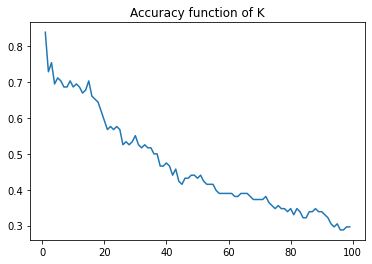

In [76]:
plt.plot(list(range(1, 100)), results)
plt.title('Accuracy function of K')
plt.show()

In [77]:
print("Max accuracy :", max(results))

Max accuracy : 0.8389830508474576
